In [11]:
from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
import sys
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
from pprint import pprint
from cloudmesh.common.dotdict import dotdict

In [12]:
list_of_dirs = [
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2', 2),
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30', 30),
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70', 70)]


In [13]:
files = []
for directory, epoch in list_of_dirs:
    gpulog = Path(directory) / "gpu0.log"
    eventlog = glob.glob(f"{directory}/*.err")[0]
    files.append(dotdict(
        {
            "epoch" : epoch,
            "eventlog": eventlog,
            "gpulog": gpulog
        })
    )

pprint (files)

[{'epoch': 2,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\\dje5dj-45737981.err',
  'gpulog': WindowsPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log')},
 {'epoch': 30,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30\\dje5dj-45737982.err',
  'gpulog': WindowsPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log')},
 {'epoch': 70,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70\\dje5dj-45737983.err',
  'gpulog': WindowsPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log')}]


In [14]:
def convert_column_to_seconds(df, col):
    # df[[name]] = df[[name]].astype('datetime64[us]')
    df[col] = pd.to_datetime(df[col], errors='coerce')
    # df[[name]] = pd.to_datetime(df[[name]], errors='coerce')
    start_t = df[col].iloc[0]
    print (start_t, type(start_t))
    for index, row in df.iterrows():

        delta = df.loc[index, col] - start_t
        df.loc[index, col] = delta.total_seconds()
    # df[name_of_seconds_column] = df[name] - start_t
    # df[[name]] = df[[name]].astype(int)/1000000000
    return df

def fix_date_format(df, col):
    # if We have T in it, we do not need to fix
    for i, row in df.iterrows():
        value = df.loc[i,col]
        if "T" not in value:
            new_date = df.loc[i,col].replace(":", " ", 1)
            df.loc[i,col] = new_date
    df[col] = pd.to_datetime(df[col])
    return df

In [15]:
def read_energy(filename=None):
    location = Shell.map_filename(filename).path
    # 1: means removing hashes
    content = readfile(location).splitlines()[1:]
    # removing #
    content[0] = content[0][2:]
    # print(content[0:10])
    content = "\n".join(content)
    content = content.replace(', ', ',')
    df = pd.read_csv(io.StringIO(content),sep=',')

    df = fix_date_format(df, "time")
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    initial_time = df.iloc[0]['time']
    df['duration'] = df['time'] - initial_time
    print('A')
    display(df)
    return df


In [16]:
def read_eventlog(filename):
    location = Shell.map_filename(filename).path
    content = readfile(location, encoding='utf-8')
    content = content.replace(', ', ',').splitlines()

    # headline = '# csv,timer,status,time,sum,start,tag,msg,uname.node,user,uname.system,platform.version'
    headline = Shell.cm_grep(content, '# csv,timer')[0]
    csv_lines = Shell.cm_grep(content, '# csv')
    csv_lines = Shell.cm_grep(csv_lines, 'Linux')
    csv_lines.insert(0, headline)
    # print("\n".join(csv_lines))
    content = "\n".join(csv_lines)
    df = pd.read_csv(io.StringIO(content),sep=',')
    df = df.rename(columns={'time':'dt'})
    df = df.rename(columns={'start':'time'})
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    df = df.drop(columns=['# csv', 'status', 'sum', 'uname.node', 'user', 'uname.system', 'platform.version', 'msg'])
    t = df.pop("time")
    df.insert(0, "time", t)
    # df = df['time'].dt.total_seconds()
    initial_time = df.iloc[0]['time']
    df['duration'] = df['time'] - initial_time
    print('B')
    # df.time.total_seconds()
    display(df)
    return df

In [17]:
def export_figure(x='Time/s', y='Energy/W', filename=None):
   plt.xlabel(x)
   plt.ylabel(y)
   base = os.path.dirname(filename.replace('_', '-').lower())
   png = base + ".png"
   pdf = base + ".pdf"
   plt.savefig(png, bbox_inches='tight', dpi=600)
   plt.savefig(pdf, bbox_inches='tight')

In [18]:
def plot_energy(filename, epoch):
    df = read_energy(filename)
    label = f'Epoch {epoch}'
    df.rename(columns = {'0 power_draw W':label}, inplace=True)
    energy = df[['time', label]]
    # display(energy)
    ax = sns.lineplot(energy)

    poi = ['INIT',
       'data head setup',
       'RunTFTCustomVersion A',
       'RunTFTCustomVersion bestfit Epoch:0',
       'RunTFTCustomVersion bestfit finalize',
       'DLprediction Iteration',
       'DLResults_Graphs timer_num:0',
       'RunTFTCustomVersion bestfit finalize VisualizeTFT event_num:0']

    for i, row in df.iterrows():
       label = row['timer']
       if label in poi:
          # print(row['timer'], row['start'])
          x = row['start']
          y = 180
          print(x, type(x), y, type(y), label, type(label))
          ax.text(x, y, label, rotation=45)
          ax.plot(x, y)

    # export_figure('Time', 'Energy', filename)
    return ax


In [19]:
list_of_filenames = [('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log', 30),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log', 70)]

for entry  in files:
    print (f"Generate output for Epoch {entry.epoch}")
    energylog = read_energy(entry.gpulog)
    eventlog = read_eventlog(entry.eventlog)

    t0_energy = energylog.time.iloc[0]
    t0_events = eventlog.time.iloc[0]

    t0 = min(t0_events, t0_energy)

    # energylog["time"] = energylog["time"] - t0
    # eventlog["time"] = eventlog["time"] - t0

    display(energylog)
    display(eventlog)



Generate output for Epoch 2
A


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W,duration
0,2022-12-21 12:55:22.564333,0,0,0,0,0,30,64.53,0 days 00:00:00
1,2022-12-21 12:55:24.945493,0,0,0,0,0,30,64.53,0 days 00:00:02.381160
2,2022-12-21 12:55:27.311910,0,0,0,0,0,30,64.53,0 days 00:00:04.747577
3,2022-12-21 12:55:29.670566,0,0,0,0,0,30,64.53,0 days 00:00:07.106233
4,2022-12-21 12:55:32.021929,0,0,0,0,0,30,64.46,0 days 00:00:09.457596
...,...,...,...,...,...,...,...,...,...
4515,2022-12-21 15:40:10.573657,0,0,0,0,0,32,71.79,0 days 02:44:48.009324
4516,2022-12-21 15:40:12.721494,0,0,0,0,0,32,71.79,0 days 02:44:50.157161
4517,2022-12-21 15:40:14.895605,0,0,0,0,0,32,71.45,0 days 02:44:52.331272
4518,2022-12-21 15:40:17.046980,0,0,0,0,0,32,71.79,0 days 02:44:54.482647


B


,time,timer,dt,tag,duration
0,2022-12-21 17:55:33,total,None,TIMER1,0 days 00:00:00
1,2022-12-21 17:55:33,total,9876.208,TIMER2,0 days 00:00:00
2,2022-12-21 17:55:48,INIT,2.261,TIMER2,0 days 00:00:15
3,2022-12-21 17:55:51,EVAL,409.961,TIMER2,0 days 00:00:18
4,2022-12-21 17:55:51,PLOTS,385.099,TIMER2,0 days 00:00:18
...,...,...,...,...,...
224,2022-12-21 20:40:06,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 02:44:33
225,2022-12-21 20:40:06,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 02:44:33
226,2022-12-21 20:40:07,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 02:44:34
227,2022-12-21 20:40:07,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 02:44:34


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W,duration
0,2022-12-21 12:55:22.564333,0,0,0,0,0,30,64.53,0 days 00:00:00
1,2022-12-21 12:55:24.945493,0,0,0,0,0,30,64.53,0 days 00:00:02.381160
2,2022-12-21 12:55:27.311910,0,0,0,0,0,30,64.53,0 days 00:00:04.747577
3,2022-12-21 12:55:29.670566,0,0,0,0,0,30,64.53,0 days 00:00:07.106233
4,2022-12-21 12:55:32.021929,0,0,0,0,0,30,64.46,0 days 00:00:09.457596
...,...,...,...,...,...,...,...,...,...
4515,2022-12-21 15:40:10.573657,0,0,0,0,0,32,71.79,0 days 02:44:48.009324
4516,2022-12-21 15:40:12.721494,0,0,0,0,0,32,71.79,0 days 02:44:50.157161
4517,2022-12-21 15:40:14.895605,0,0,0,0,0,32,71.45,0 days 02:44:52.331272
4518,2022-12-21 15:40:17.046980,0,0,0,0,0,32,71.79,0 days 02:44:54.482647


,time,timer,dt,tag,duration
0,2022-12-21 17:55:33,total,None,TIMER1,0 days 00:00:00
1,2022-12-21 17:55:33,total,9876.208,TIMER2,0 days 00:00:00
2,2022-12-21 17:55:48,INIT,2.261,TIMER2,0 days 00:00:15
3,2022-12-21 17:55:51,EVAL,409.961,TIMER2,0 days 00:00:18
4,2022-12-21 17:55:51,PLOTS,385.099,TIMER2,0 days 00:00:18
...,...,...,...,...,...
224,2022-12-21 20:40:06,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 02:44:33
225,2022-12-21 20:40:06,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 02:44:33
226,2022-12-21 20:40:07,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 02:44:34
227,2022-12-21 20:40:07,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 02:44:34


Generate output for Epoch 30
A


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W,duration
0,2022-12-21 12:55:22.538575,0,0,0,0,0,28,62.86,0 days 00:00:00
1,2022-12-21 12:55:24.710997,0,0,0,0,0,28,62.86,0 days 00:00:02.172422
2,2022-12-21 12:55:26.734467,0,0,0,0,0,28,62.86,0 days 00:00:04.195892
3,2022-12-21 12:55:28.920974,0,0,0,0,0,28,62.86,0 days 00:00:06.382399
4,2022-12-21 12:55:31.113173,0,0,0,0,0,28,62.86,0 days 00:00:08.574598
...,...,...,...,...,...,...,...,...,...
12312,2022-12-21 20:21:32.780166,0,0,0,0,0,30,70.40,0 days 07:26:10.241591
12313,2022-12-21 20:21:34.964695,0,0,0,0,0,30,70.40,0 days 07:26:12.426120
12314,2022-12-21 20:21:37.140739,0,0,0,0,0,30,70.68,0 days 07:26:14.602164
12315,2022-12-21 20:21:39.323510,0,0,0,0,0,30,70.68,0 days 07:26:16.784935


B


,time,timer,dt,tag,duration
0,2022-12-21 17:55:33,total,None,TIMER1,0 days 00:00:00
1,2022-12-21 17:55:33,total,26757.542,TIMER2,0 days 00:00:00
2,2022-12-21 17:55:48,INIT,2.095,TIMER2,0 days 00:00:15
3,2022-12-21 17:55:51,EVAL,413.412,TIMER2,0 days 00:00:18
4,2022-12-21 17:55:51,PLOTS,388.651,TIMER2,0 days 00:00:18
...,...,...,...,...,...
420,2022-12-22 01:21:28,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 07:25:55
421,2022-12-22 01:21:28,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 07:25:55
422,2022-12-22 01:21:28,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 07:25:55
423,2022-12-22 01:21:28,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 07:25:55


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W,duration
0,2022-12-21 12:55:22.538575,0,0,0,0,0,28,62.86,0 days 00:00:00
1,2022-12-21 12:55:24.710997,0,0,0,0,0,28,62.86,0 days 00:00:02.172422
2,2022-12-21 12:55:26.734467,0,0,0,0,0,28,62.86,0 days 00:00:04.195892
3,2022-12-21 12:55:28.920974,0,0,0,0,0,28,62.86,0 days 00:00:06.382399
4,2022-12-21 12:55:31.113173,0,0,0,0,0,28,62.86,0 days 00:00:08.574598
...,...,...,...,...,...,...,...,...,...
12312,2022-12-21 20:21:32.780166,0,0,0,0,0,30,70.40,0 days 07:26:10.241591
12313,2022-12-21 20:21:34.964695,0,0,0,0,0,30,70.40,0 days 07:26:12.426120
12314,2022-12-21 20:21:37.140739,0,0,0,0,0,30,70.68,0 days 07:26:14.602164
12315,2022-12-21 20:21:39.323510,0,0,0,0,0,30,70.68,0 days 07:26:16.784935


,time,timer,dt,tag,duration
0,2022-12-21 17:55:33,total,None,TIMER1,0 days 00:00:00
1,2022-12-21 17:55:33,total,26757.542,TIMER2,0 days 00:00:00
2,2022-12-21 17:55:48,INIT,2.095,TIMER2,0 days 00:00:15
3,2022-12-21 17:55:51,EVAL,413.412,TIMER2,0 days 00:00:18
4,2022-12-21 17:55:51,PLOTS,388.651,TIMER2,0 days 00:00:18
...,...,...,...,...,...
420,2022-12-22 01:21:28,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 07:25:55
421,2022-12-22 01:21:28,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 07:25:55
422,2022-12-22 01:21:28,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 07:25:55
423,2022-12-22 01:21:28,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 07:25:55


Generate output for Epoch 70
A


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W,duration
0,2022-12-21 12:55:22.567625,0,0,0,0,0,29,61.81,0 days 00:00:00
1,2022-12-21 12:55:24.944998,0,0,0,0,0,29,61.81,0 days 00:00:02.377373
2,2022-12-21 12:55:27.312904,0,0,0,0,0,29,61.81,0 days 00:00:04.745279
3,2022-12-21 12:55:29.670564,0,0,0,0,0,29,61.81,0 days 00:00:07.102939
4,2022-12-21 12:55:32.022750,0,0,0,0,0,29,61.81,0 days 00:00:09.455125
...,...,...,...,...,...,...,...,...,...
25104,2022-12-22 02:56:19.324727,0,0,0,0,0,31,68.51,0 days 14:00:56.757102
25105,2022-12-22 02:56:20.978700,0,0,0,0,0,31,68.51,0 days 14:00:58.411075
25106,2022-12-22 02:56:22.615679,0,0,0,0,0,31,68.51,0 days 14:01:00.048054
25107,2022-12-22 02:56:24.252907,0,0,0,0,0,32,87.30,0 days 14:01:01.685282


B


,time,timer,dt,tag,duration
0,2022-12-21 17:55:33,total,None,TIMER1,0 days 00:00:00
1,2022-12-21 17:55:33,total,50441.073,TIMER2,0 days 00:00:00
2,2022-12-21 17:55:48,INIT,2.579,TIMER2,0 days 00:00:15
3,2022-12-21 17:55:51,EVAL,408.511,TIMER2,0 days 00:00:18
4,2022-12-21 17:55:51,PLOTS,383.499,TIMER2,0 days 00:00:18
...,...,...,...,...,...
700,2022-12-22 07:56:11,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 14:00:38
701,2022-12-22 07:56:11,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 14:00:38
702,2022-12-22 07:56:12,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 14:00:39
703,2022-12-22 07:56:12,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 14:00:39


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W,duration
0,2022-12-21 12:55:22.567625,0,0,0,0,0,29,61.81,0 days 00:00:00
1,2022-12-21 12:55:24.944998,0,0,0,0,0,29,61.81,0 days 00:00:02.377373
2,2022-12-21 12:55:27.312904,0,0,0,0,0,29,61.81,0 days 00:00:04.745279
3,2022-12-21 12:55:29.670564,0,0,0,0,0,29,61.81,0 days 00:00:07.102939
4,2022-12-21 12:55:32.022750,0,0,0,0,0,29,61.81,0 days 00:00:09.455125
...,...,...,...,...,...,...,...,...,...
25104,2022-12-22 02:56:19.324727,0,0,0,0,0,31,68.51,0 days 14:00:56.757102
25105,2022-12-22 02:56:20.978700,0,0,0,0,0,31,68.51,0 days 14:00:58.411075
25106,2022-12-22 02:56:22.615679,0,0,0,0,0,31,68.51,0 days 14:01:00.048054
25107,2022-12-22 02:56:24.252907,0,0,0,0,0,32,87.30,0 days 14:01:01.685282


,time,timer,dt,tag,duration
0,2022-12-21 17:55:33,total,None,TIMER1,0 days 00:00:00
1,2022-12-21 17:55:33,total,50441.073,TIMER2,0 days 00:00:00
2,2022-12-21 17:55:48,INIT,2.579,TIMER2,0 days 00:00:15
3,2022-12-21 17:55:51,EVAL,408.511,TIMER2,0 days 00:00:18
4,2022-12-21 17:55:51,PLOTS,383.499,TIMER2,0 days 00:00:18
...,...,...,...,...,...
700,2022-12-22 07:56:11,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 14:00:38
701,2022-12-22 07:56:11,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 14:00:38
702,2022-12-22 07:56:12,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 14:00:39
703,2022-12-22 07:56:12,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2,0 days 14:00:39


A


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W,duration
0,2022-12-21 12:55:22.564333,0,0,0,0,0,30,64.53,0 days 00:00:00
1,2022-12-21 12:55:24.945493,0,0,0,0,0,30,64.53,0 days 00:00:02.381160
2,2022-12-21 12:55:27.311910,0,0,0,0,0,30,64.53,0 days 00:00:04.747577
3,2022-12-21 12:55:29.670566,0,0,0,0,0,30,64.53,0 days 00:00:07.106233
4,2022-12-21 12:55:32.021929,0,0,0,0,0,30,64.46,0 days 00:00:09.457596
...,...,...,...,...,...,...,...,...,...
4515,2022-12-21 15:40:10.573657,0,0,0,0,0,32,71.79,0 days 02:44:48.009324
4516,2022-12-21 15:40:12.721494,0,0,0,0,0,32,71.79,0 days 02:44:50.157161
4517,2022-12-21 15:40:14.895605,0,0,0,0,0,32,71.45,0 days 02:44:52.331272
4518,2022-12-21 15:40:17.046980,0,0,0,0,0,32,71.79,0 days 02:44:54.482647


A


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W,duration
0,2022-12-21 12:55:22.564333,0,0,0,0,0,30,64.53,0 days 00:00:00
1,2022-12-21 12:55:24.945493,0,0,0,0,0,30,64.53,0 days 00:00:02.381160
2,2022-12-21 12:55:27.311910,0,0,0,0,0,30,64.53,0 days 00:00:04.747577
3,2022-12-21 12:55:29.670566,0,0,0,0,0,30,64.53,0 days 00:00:07.106233
4,2022-12-21 12:55:32.021929,0,0,0,0,0,30,64.46,0 days 00:00:09.457596
...,...,...,...,...,...,...,...,...,...
4515,2022-12-21 15:40:10.573657,0,0,0,0,0,32,71.79,0 days 02:44:48.009324
4516,2022-12-21 15:40:12.721494,0,0,0,0,0,32,71.79,0 days 02:44:50.157161
4517,2022-12-21 15:40:14.895605,0,0,0,0,0,32,71.45,0 days 02:44:52.331272
4518,2022-12-21 15:40:17.046980,0,0,0,0,0,32,71.79,0 days 02:44:54.482647


KeyError: 'timer '

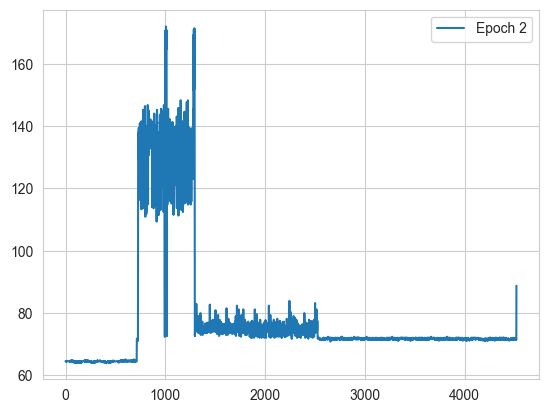

In [20]:
read_energy('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log')
ax = plot_energy('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2)
